# Currency exchange

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as k
import pandas_profiling as pdp
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Datasets/CambioDivisas/Foreign_Exchange_Rates.csv', na_values='ND', index_col=0)
df.head()

,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,INDIA - INDIAN RUPEE/US$,...,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.8050,1.4465,8.2798,7.7765,43.55,...,1.6563,7.3290,101.70,3.8,7.964,8.4430,72.30,1.5808,31.38,36.97
1,2000-01-04,1.5239,0.9700,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,...,1.6535,7.2180,103.09,3.8,7.934,8.3600,72.65,1.5565,30.60,37.13
2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.8560,1.4518,8.2798,7.7780,43.55,...,1.6560,7.2080,103.77,3.8,7.935,8.3530,72.95,1.5526,30.80,37.10
3,2000-01-06,1.5291,0.9686,1.9436,0.6070,1.8400,1.4571,8.2797,7.7785,43.55,...,1.6655,7.2125,105.19,3.8,7.940,8.3675,72.95,1.5540,31.75,37.62
4,2000-01-07,1.5272,0.9714,1.9380,0.6104,1.8310,1.4505,8.2794,7.7783,43.55,...,1.6625,7.2285,105.17,3.8,7.966,8.4150,73.15,1.5623,30.85,37.30


In [3]:
pdp.ProfileReport(df)

Number of variables,23
Number of observations,5217
Total Missing (%),2.1%
Total size in memory,978.2 KiB
Average record size in memory,192.0 B
Numeric,13
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,9


## Empty values 
Percentage of empty values per country currency

In [3]:
df.isnull().sum()*100/df.shape[0]

Time Serie                                   0.000000
AUSTRALIA - AUSTRALIAN DOLLAR/US$            3.795285
EURO AREA - EURO/US$                         3.795285
NEW ZEALAND - NEW ZELAND DOLLAR/US$          3.795285
UNITED KINGDOM - UNITED KINGDOM POUND/US$    3.795285
BRAZIL - REAL/US$                            3.795285
CANADA - CANADIAN DOLLAR/US$                 3.795285
CHINA - YUAN/US$                             3.776117
HONG KONG - HONG KONG DOLLAR/US$             3.795285
INDIA - INDIAN RUPEE/US$                     3.814453
KOREA - WON/US$                              3.795285
MEXICO - MEXICAN PESO/US$                    3.795285
SOUTH AFRICA - RAND/US$                      3.795285
SINGAPORE - SINGAPORE DOLLAR/US$             3.795285
DENMARK - DANISH KRONE/US$                   3.795285
JAPAN - YEN/US$                              3.795285
MALAYSIA - RINGGIT/US$                       3.795285
NORWAY - NORWEGIAN KRONE/US$                 3.795285
SWEDEN - KRONA/US$          

For purposes of the experiment I will interpolate the empty values in order to not have missing information in any currecy.

In [4]:
df.interpolate(inplace=True)

[Text(0, 0.5, 'Currency Value'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Euro value per time vs US dollar')]

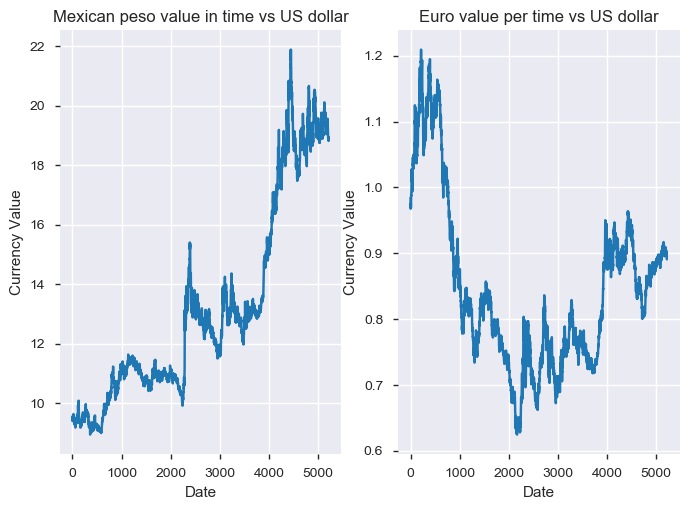

In [9]:
fig, (ax_e, ax_i) = plt.subplots(1,2, sharex=True)
ax_e.plot(df['MEXICO - MEXICAN PESO/US$'], label = 'Mexican Peso')
ax_e.set(title='Mexican peso value in time vs US dollar', xlabel='Date', ylabel='Currency Value')

ax_i.plot(df['EURO AREA - EURO/US$'], label = 'Euro')
ax_i.set(title='Euro value per time vs US dollar', xlabel='Date', ylabel='Currency Value')


## Time series forecasting.
A very used method for time series forecasting is recurrent neural networks. For this method the data must have 3 dimensions. The batch size, the time window and the actual values in the timeseries. Since I will be doing one currency it will be a univariate time series. This means the secodn and third dimensions are of size one.

In [5]:
np_mexico = df['MEXICO - MEXICAN PESO/US$'].values.reshape(-1,1)
np_euro = df['EURO AREA - EURO/US$'].values.reshape(-1,1)

## Model for Mexican peso
The entries in the dataset were per day. Therefore, I decided to create a model that forecasts the price of the mexican peso using the last 2 months of data as input. For training I will use the earlier esntries and test against the last 1000 entries of the dataset.

First normalization is required. I will use min max scaler. There is a fucntion in sklearn, however I will do it manuaaly for fun.

In [6]:
max_mexico, min_mexico = np_mexico.min(), np_mexico.max()
np_mexico = (np_mexico-min_mexico)/(max_mexico-min_mexico)

In [7]:
trn = np_mexico[:-1000]
tst = np_mexico[-1000:]
print(trn.shape, tst.shape)

(4217, 1) (1000, 1)


In [8]:
def build_trn(ts_length, data):
    x, y = [], []
    for i in range(len(data)-ts_length-1):
        x.append(data[i:(i+ts_length),0])
        y.append(data[i+ts_length,0])
    return np.array(x),np.array(y)

In [38]:
window_size = 1
X_trn, y_trn = build_trn(window_size, trn)
X_trn = np.expand_dims(X_trn,-1)
print(X_trn.shape, y_trn.shape)
X_tst,y_tst = build_trn(window_size,tst)
X_tst = np.expand_dims(X_tst, -1)
print(X_tst.shape, y_tst.shape)

(4215, 1, 1) (4215,)
(998, 1, 1) (998,)


In [39]:
input_layer = k.layers.Input(X_trn.shape[1:])
hidden_layer = k.layers.CuDNNGRU(100)(input_layer)
output_layer = k.layers.Dense(1)(hidden_layer)
model = k.Model(inputs=input_layer, outputs=output_layer)

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 100)               30900     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [41]:
opt = k.optimizers.adam(lr=0.001)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_trn, y_trn, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
4215/4215 [==============================] - 1s 187us/step - loss: 0.1035
Epoch 2/10
4215/4215 [==============================] - 0s 104us/step - loss: 0.0067
Epoch 3/10
4215/4215 [==============================] - 0s 95us/step - loss: 0.0050
Epoch 4/10
4215/4215 [==============================] - 0s 97us/step - loss: 0.0033
Epoch 5/10
4215/4215 [==============================] - 0s 94us/step - loss: 0.0019
Epoch 6/10
4215/4215 [==============================] - 0s 96us/step - loss: 9.0929e-04
Epoch 7/10
4215/4215 [==============================] - 0s 97us/step - loss: 3.3027e-04
Epoch 8/10
4215/4215 [==============================] - 0s 97us/step - loss: 1.0631e-04
Epoch 9/10
4215/4215 [==============================] - 0s 92us/step - loss: 5.1685e-05
Epoch 10/10
4215/4215 [==============================] - 0s 96us/step - loss: 4.4069e-05


## Recovering original values

In [42]:
y_hat = model.predict(X_tst)
y_hat = ((max_mexico-min_mexico)*y_hat) + min_mexico
y_tst = ((max_mexico-min_mexico)*y_tst) + min_mexico

<Figure size 720x720 with 0 Axes>

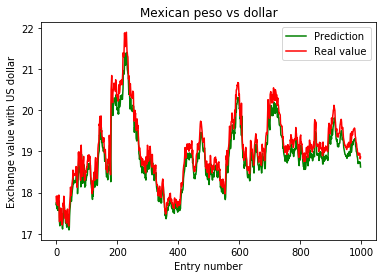

<Figure size 720x720 with 0 Axes>

In [43]:
plt.plot(y_hat, label='Prediction', color='green')
plt.plot(y_tst, label='Real value', color='red')
plt.legend()
plt.title('Mexican peso vs dollar')
plt.xlabel('Entry number')
plt.ylabel('Exchange value with US dollar')
plt.figure(figsize=(10,10))

In [44]:
mse = (np.mean((y_hat-y_tst)**2))**0.5
print(mse)

1.1460986195223781


## Analysis the model learning curve

Text(0, 0.5, 'MSE')

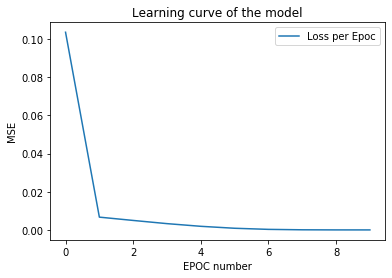

In [45]:
plt.plot(history.history['loss'], label='Loss per Epoc')
plt.title('Learning curve of the model')
plt.xlabel('EPOC number')
plt.legend()
plt.ylabel('MSE')